In [97]:
# 必要なライブラリのインポート．
from abc import ABC, abstractmethod
import os
import glob
from collections import deque
from time import time
from datetime import timedelta
import pickle
from base64 import b64encode
import math
import numpy as np
np.bool8 = np.bool
import torch
from torch import nn
from torch.distributions import Normal
import torch.nn.functional as F
from torch.optim.lr_scheduler import LinearLR
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt
from IPython.display import HTML

# matplotlibをColab上で描画するためのコマンド．
%matplotlib inline

In [2]:
def play_mp4(folder_path="videos"):
    """ColabでMP4動画を表示します"""
    video_files = glob.glob(os.path.join(folder_path, "*.mp4"))
    if not video_files:
        print(f"動画ファイルがフォルダ '{folder_path}' に見つかりません。")
        return

    latest_file = max(video_files, key=os.path.getctime)
    print(f"表示中の動画: {latest_file}")

    with open(latest_file, 'rb') as f:
        video_data = f.read()

    video_url = f"data:video/mp4;base64,{b64encode(video_data).decode()}"
    return HTML(f"""
    <video width=600 controls>
        <source src="{video_url}" type="video/mp4">
    </video>
    """)

In [3]:
def preprocess_state(state, device):
    """(高さ, 幅, チャンネル)のNumpy配列を(1, チャンネル, 高さ, 幅)のTensorに変換"""
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).permute(2, 0, 1) / 255.0
    return state_tensor.unsqueeze(0)

In [4]:
env = gym.make('CarRacing-v3', render_mode='rgb_array')
video_folder = "random_run_videos"
env = RecordVideo(env, video_folder, episode_trigger=lambda e: True)

print('observation space: ', env.observation_space)
print('action space: ', env.action_space)

env.reset()
done = False

# 終了シグナル(done=True)が返ってくるまで，ランダムに環境を動かす．
while (not done):
  action = env.action_space.sample()
  obs, reward, terminated, truncated, info = env.step(action)
  done = terminated or truncated

env.close()

/opt/miniconda3/envs/car-racing-env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/todayuto/Downloads/random_run_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


observation space:  Box(0, 255, (96, 96, 3), uint8)
action space:  Box([-1.  0.  0.], 1.0, (3,), float32)


In [5]:
play_mp4(video_folder)

表示中の動画: random_run_videos/rl-video-episode-0.mp4


In [100]:
class Trainer:
    """学習全体を管理するクラス"""
    def __init__(self, env, env_test, algo, seed=0, num_steps=10**6, eval_interval=10**4, num_eval_episodes=3, model_dir='best_model'):
        self.env = env
        self.env_test = env_test
        self.algo = algo
        self.seed = seed
        self.returns = {'step': [], 'return': []}
        self.num_steps = num_steps
        self.eval_interval = eval_interval
        self.num_eval_episodes = num_eval_episodes
        self.model_dir = model_dir
        self.best_mean_return = -float('inf')

    def train(self):
        self.start_time = time()
        t = 0
        state, _ = self.env.reset(seed=self.seed)
        for steps in range(1, self.num_steps + 1):
            state, t = self.algo.step(self.env, state, t, steps)
            if self.algo.is_update(steps):
                self.algo.update()
            if steps % self.eval_interval == 0:
                self.evaluate(steps)

    def evaluate(self, steps):
        returns = []
        for _ in range(self.num_eval_episodes):
            state, _ = self.env_test.reset(seed=2**31 - 1 - self.seed)
            episode_return = 0.0
            done = False
            while not done:
                action = self.algo.exploit(state)
                state, reward, terminated, truncated, _ = self.env_test.step(action)
                done = terminated or truncated
                episode_return += reward
            returns.append(episode_return)

        mean_return = np.mean(returns)
        self.returns['step'].append(steps)
        self.returns['return'].append(mean_return)
        print(f'Num steps: {steps:<6}   Return: {mean_return:<5.1f}   Time: {self.time}')

        if mean_return > self.best_mean_return:
            self.best_mean_return = mean_return
            print(f"最高スコアを記録: {self.best_mean_return:.1f}")
            self.algo.save_models(self.model_dir)

    def visualize(self, folder="final_agent_videos"):
        """学習済みエージェントの動画を記録・表示"""
        vis_env = gym.make('CarRacing-v3', render_mode='rgb_array')
        vis_env = RecordVideo(vis_env, folder, episode_trigger=lambda e: True)
        state, _ = vis_env.reset(seed=self.seed)
        done = False
        while not done:
            action = self.algo.exploit(state)
            state, _, terminated, truncated, _ = vis_env.step(action)
            done = terminated or truncated
        vis_env.close()
        return play_mp4(folder)

    def plot(self):
        """学習曲線をプロット"""
        fig = plt.figure(figsize=(8, 6))
        plt.plot(self.returns['step'], self.returns['return'])
        plt.xlabel('Steps', fontsize=18)
        plt.ylabel('Return', fontsize=18)
        plt.yticks(np.arange(-100, 1001, 100))
        plt.title(f'Learning Curve for {self.env.unwrapped.spec.id}', fontsize=20)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    @property
    def time(self):
        return str(timedelta(seconds=int(time() - self.start_time)))

In [7]:
class Algorithm(ABC):
    @abstractmethod
    def explore(self, state):
        pass
    @abstractmethod
    def exploit(self, state):
        pass
    @abstractmethod
    def is_update(self, steps):
        pass
    @abstractmethod
    def step(self, env, state, t, steps):
        pass
    @abstractmethod
    def update(self):
        pass

In [42]:
class RunningMeanStd:
    """ 報酬の移動平均と移動分散/標準偏差をオンラインで計算するクラス """
    def __init__(self, shape=(), epsilon=1e-8):
        self.mean = np.zeros(shape, 'float64')
        self.var = np.ones(shape, 'float64')
        self.count = epsilon

    def update(self, x):
        """ Welford's online algorithm を用いて統計量を更新 """
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]

        delta = batch_mean - self.mean
        tot_count = self.count + batch_count

        new_mean = self.mean + delta * batch_count / tot_count
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        m_2 = m_a + m_b + np.square(delta) * self.count * batch_count / tot_count
        new_var = m_2 / tot_count

        self.mean = new_mean
        self.var = new_var
        self.count = tot_count

In [8]:
def calculate_log_pi(log_stds, noises, actions):
    """ 確率論的な行動の確率密度を返す． """
    # ガウス分布 `N(0, stds * I)` における `noises * stds` の確率密度の対数(= \log \pi(u|a))を計算する．
    # [演習]
    # 確率密度の対数(= \log \pi(u|a))を計算しましょう。
    # 講義スライド（20211117_lec-2_2_発展的方策勾配法.pdf）のスライドの最後の2ページに計算方法が書いてあります。
    log_pis = -0.5 * math.log(2 * math.pi) * log_stds.size(-1) - log_stds.sum(dim=-1, keepdim=True) - (0.5 * noises.pow(2)).sum(dim=-1, keepdim=True)
    log_pis -= torch.log(1 - actions.pow(2) + 1e-6).sum(dim=-1, keepdim=True)

    return log_pis

In [9]:
def reparameterize(means, log_stds):
    """ Reparameterization Trickを用いて，確率論的な行動とその確率密度を返す． """
    stds = log_stds.exp()
    # 標準ガウス分布から，ノイズをサンプリングする．
    noises = torch.randn_like(means)
    # Reparameterization Trickを用いて，N(means, stds)からのサンプルを計算する．
    us = means + noises * stds
    # tanh　を適用し，確率論的な行動を計算する．
    actions = torch.tanh(us)

    # 確率論的な行動の確率密度の対数を計算する．
    log_pis = calculate_log_pi(log_stds, noises, actions)

    return actions, log_pis

In [10]:
def atanh(x):
    """ tanh の逆関数． """
    return 0.5 * (torch.log(1 + x + 1e-6) - torch.log(1 - x + 1e-6))


def evaluate_lop_pi(means, log_stds, actions):
    """ 平均(mean)，標準偏差の対数(log_stds)でパラメータ化した方策における，行動(actions)の確率密度の対数を計算する． """
    noises = (atanh(actions) - means) / (log_stds.exp() + 1e-8)
    return calculate_log_pi(log_stds, noises, actions)

In [ ]:
class CNN(nn.Module):
    """画像から特徴量を抽出するCNN"""
    def __init__(self, input_channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

    def forward(self, states):
        return self.net(states)

In [12]:
class PPOActor(nn.Module):
    """PPOのActorネットワーク"""
    def __init__(self, cnn_output_dim, action_shape):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(cnn_output_dim, 256),
            nn.ReLU(),
            nn.Linear(256, action_shape[0]),
        )
        self.log_stds = nn.Parameter(torch.zeros(1, action_shape[0]))

    def forward(self, features):
        return torch.tanh(self.fc(features))

    def sample(self, features):
        return reparameterize(self.fc(features), self.log_stds)

In [13]:
class PPOCritic(nn.Module):
    """PPOのCriticネットワーク"""
    def __init__(self, cnn_output_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(cnn_output_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, features):
        return self.fc(features)

In [30]:
def calculate_advantage(values, rewards, dones, next_values, gamma=0.995, lambd=0.997):

    # TD誤差を計算する．
    deltas = rewards + gamma * next_values * (1 - dones) - values

    # GAEを初期化する．
    advantages = torch.empty_like(rewards)

    # 終端ステップを計算する．
    advantages[-1] = deltas[-1]

    # 終端ステップの1つ前から，順番にGAEを計算していく．
    for t in reversed(range(rewards.size(0) - 1)):
        advantages[t] = deltas[t] + gamma * lambd * (1 - dones[t]) * advantages[t + 1]

    # 状態価値のターゲットをλ-収益として計算する．
    targets = advantages + values

    # GAEを標準化する．
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    return targets, advantages

In [15]:
class RolloutBuffer:
    """ロールアウトデータを保存するバッファ"""
    def __init__(self, buffer_size, state_shape, action_shape, device):
        self.states = torch.empty((buffer_size, *state_shape), dtype=torch.uint8, device=device)
        self.actions = torch.empty((buffer_size, *action_shape), dtype=torch.float32, device=device)
        self.rewards = torch.empty((buffer_size, 1), dtype=torch.float32, device=device)
        self.dones = torch.empty((buffer_size, 1), dtype=torch.float32, device=device)
        self.log_pis = torch.empty((buffer_size, 1), dtype=torch.float32, device=device)
        self._p = 0
        self.buffer_size = buffer_size

    def append(self, state, action, reward, done, log_pi):
        self.states[self._p].copy_(torch.from_numpy(state))
        self.actions[self._p].copy_(torch.from_numpy(action))
        self.rewards[self._p] = float(reward)
        self.dones[self._p] = float(done)
        self.log_pis[self._p] = float(log_pi)
        self._p = (self._p + 1) % self.buffer_size

    def get(self):
        assert self._p == 0, 'Buffer needs to be full before training.'
        return self.states, self.actions, self.rewards, self.dones, self.log_pis

In [ ]:
class PPO(Algorithm):
    def __init__(self, state_shape, action_shape, device, seed=0,
                 batch_size=256, gamma=0.99, lr=3e-5,
                 rollout_length=2048, num_updates=10, clip_eps=0.2, lambd=0.95,
                 coef_ent=0.01, max_grad_norm=0.5):
        super().__init__()
        torch.manual_seed(seed)
        if device.type == 'cuda': torch.cuda.manual_seed(seed)
        np.random.seed(seed)

        self.buffer = RolloutBuffer(rollout_length, state_shape, action_shape, device)
        self.device = device

        # モデルの構築
        dummy_state = torch.zeros(1, state_shape[2], state_shape[0], state_shape[1], device=device)
        self.cnn = CNN(input_channels=state_shape[2]).to(device)
        cnn_output_dim = self.cnn(dummy_state).shape[-1]
        self.actor = PPOActor(cnn_output_dim, action_shape).to(device)
        self.critic = PPOCritic(cnn_output_dim).to(device)
        self.optim = torch.optim.Adam(list(self.cnn.parameters()) + list(self.actor.parameters()) + list(self.critic.parameters()), lr=lr)

        self.batch_size = batch_size
        self.gamma = gamma
        self.rollout_length = rollout_length
        self.num_updates = num_updates
        self.clip_eps = clip_eps
        self.lambd = lambd
        self.coef_ent = coef_ent
        self.max_grad_norm = max_grad_norm

        self.off_course_threshold = 100
        self.off_course_counter = 0


    def explore(self, state):
        state_tensor = preprocess_state(state, self.device)
        with torch.no_grad():
            features = self.cnn(state_tensor)
            action, log_pi = self.actor.sample(features)
        return action.cpu().numpy()[0], log_pi.item()

    def exploit(self, state):
        state_tensor = preprocess_state(state, self.device)
        with torch.no_grad():
            features = self.cnn(state_tensor)
            action = self.actor(features)
        return action.cpu().numpy()[0]

    def is_update(self, steps):
        return steps % self.rollout_length == 0

    def step(self, env, state, t, steps):
        t += 1
        action, log_pi = self.explore(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        if reward < 0:
            self.off_course_counter += 1
        else:
            self.off_course_counter = 0

        if self.off_course_counter >= self.off_course_threshold:
            done = True
            reward = -100

        done_masked = done if not truncated else False
        self.buffer.append(state, action, reward, done_masked, log_pi)

        if done:
            t = 0
            next_state, _ = env.reset()
            self.off_course_counter = 0

        return next_state, t

    def update(self):
        states, actions, rewards, dones, log_pis_old = self.buffer.get()
        processed_states = states.float().permute(0, 3, 1, 2) / 255.0

        with torch.no_grad():
            features = self.cnn(processed_states)
            values = self.critic(features)
            next_features = self.cnn(torch.roll(processed_states, -1, 0))
            next_values = self.critic(next_features)

        targets, advantages = calculate_advantage(values, rewards, dones, next_values, self.gamma, self.lambd)

        for _ in range(self.num_updates):
            indices = np.random.permutation(self.rollout_length)
            for start in range(0, self.rollout_length, self.batch_size):
                idx = indices[start:start+self.batch_size]
                features_batch = self.cnn(processed_states[idx])

                # Critic損失
                loss_critic = (self.critic(features_batch) - targets[idx]).pow(2).mean()

                # Actor損失
                log_pis = evaluate_lop_pi(self.actor.fc(features_batch), self.actor.log_stds, actions[idx])
                mean_entropy = -log_pis.mean()
                ratios = (log_pis - log_pis_old[idx]).exp()
                loss_actor1 = -ratios * advantages[idx]
                loss_actor2 = -torch.clamp(ratios, 1.0 - self.clip_eps, 1.0 + self.clip_eps) * advantages[idx]
                loss_actor = torch.max(loss_actor1, loss_actor2).mean() - self.coef_ent * mean_entropy

                # 合計損失
                total_loss = loss_actor + 0.5 * loss_critic

                self.optim.zero_grad()
                total_loss.backward()
                nn.utils.clip_grad_norm_(self.cnn.parameters(), self.max_grad_norm)
                nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
                nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
                self.optim.step()

    def save_models(self, save_dir):
        """モデルの重みを保存する"""
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        torch.save(self.cnn.state_dict(), os.path.join(save_dir, 'cnn.pth'))
        torch.save(self.actor.state_dict(), os.path.join(save_dir, 'actor.pth'))
        torch.save(self.critic.state_dict(), os.path.join(save_dir, 'critic.pth'))
        print(f"モデルを {save_dir} に保存しました。")

    def load_models(self, load_dir):
        """モデルの重みを読み込む"""
        self.cnn.load_state_dict(torch.load(os.path.join(load_dir, 'cnn.pth')))
        self.actor.load_state_dict(torch.load(os.path.join(load_dir, 'actor.pth')))
        self.critic.load_state_dict(torch.load(os.path.join(load_dir, 'critic.pth')))
        print(f"モデルを {load_dir} から読み込みました。")

In [ ]:
SEED = 0
NUM_STEPS = 5 * 10**5
EVAL_INTERVAL = 2048

env = gym.make('CarRacing-v3', render_mode='rgb_array', max_episode_steps=1000)
env_test = gym.make('CarRacing-v3', render_mode='rgb_array', max_episode_steps=1000)

algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    reward_scaling=False
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
    model_dir='model_ppo_3'
)

In [20]:
trainer.train()

Num steps: 2048     Return: -61.9   Time: 0:00:31
最高スコアを記録: -61.9
モデルを best_model_3 に保存しました。
Num steps: 4096     Return: -23.9   Time: 0:01:03
最高スコアを記録: -23.9
モデルを best_model_3 に保存しました。
Num steps: 6144     Return: 169.9   Time: 0:01:37
最高スコアを記録: 169.9
モデルを best_model_3 に保存しました。
Num steps: 8192     Return: -57.0   Time: 0:02:00
Num steps: 10240    Return: -53.0   Time: 0:02:21
Num steps: 12288    Return: -61.9   Time: 0:02:54
Num steps: 14336    Return: 41.9    Time: 0:03:28
Num steps: 16384    Return: -75.8   Time: 0:04:00
Num steps: 18432    Return: -41.2   Time: 0:04:30
Num steps: 20480    Return: -75.8   Time: 0:05:03
Num steps: 22528    Return: 176.8   Time: 0:05:37
最高スコアを記録: 176.8
モデルを best_model_3 に保存しました。
Num steps: 24576    Return: 10.7    Time: 0:06:11
Num steps: 26624    Return: 221.8   Time: 0:06:46
最高スコアを記録: 221.8
モデルを best_model_3 に保存しました。
Num steps: 28672    Return: 31.5    Time: 0:07:23
Num steps: 30720    Return: 31.5    Time: 0:07:58
Num steps: 32768    Return: 183.7  

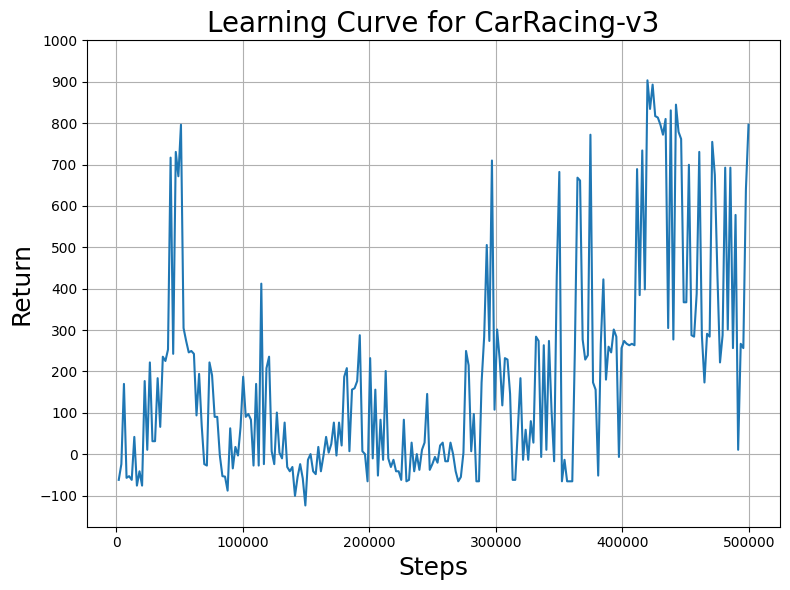

In [21]:
trainer.plot()

In [157]:
env.close()
env_test.close()

In [158]:
env = gym.make('CarRacing-v3', render_mode='rgb_array', max_episode_steps=3000)
best_ppo_algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

best_ppo_algo.load_models('best_ppo_1')

video_folder = "best_ppo_1_videos"
env = RecordVideo(env, video_folder, episode_trigger=lambda e: True)
state, _ = env.reset(seed=1)
done = False
while not done:
    action = best_ppo_algo.exploit(state)
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
env.close()


play_mp4(video_folder)

モデルを best_ppo_1 から読み込みました。


/opt/miniconda3/envs/car-racing-env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/todayuto/Downloads/best_ppo_1_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


表示中の動画: best_ppo_1_videos/rl-video-episode-0.mp4


In [167]:
env = gym.make('CarRacing-v3', render_mode='rgb_array', max_episode_steps=3000)
best_ppo_algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

best_ppo_algo.load_models('best_ppo_1')

モデルを best_ppo_1 から読み込みました。


可視化用の画像を収集中...
  - ステップ 100 の画像を保存しました。
  - ステップ 200 の画像を保存しました。
  - ステップ 300 の画像を保存しました。
  - ステップ 400 の画像を保存しました。
  - ステップ 500 の画像を保存しました。
  - ステップ 600 の画像を保存しました。
画像の収集が完了しました。


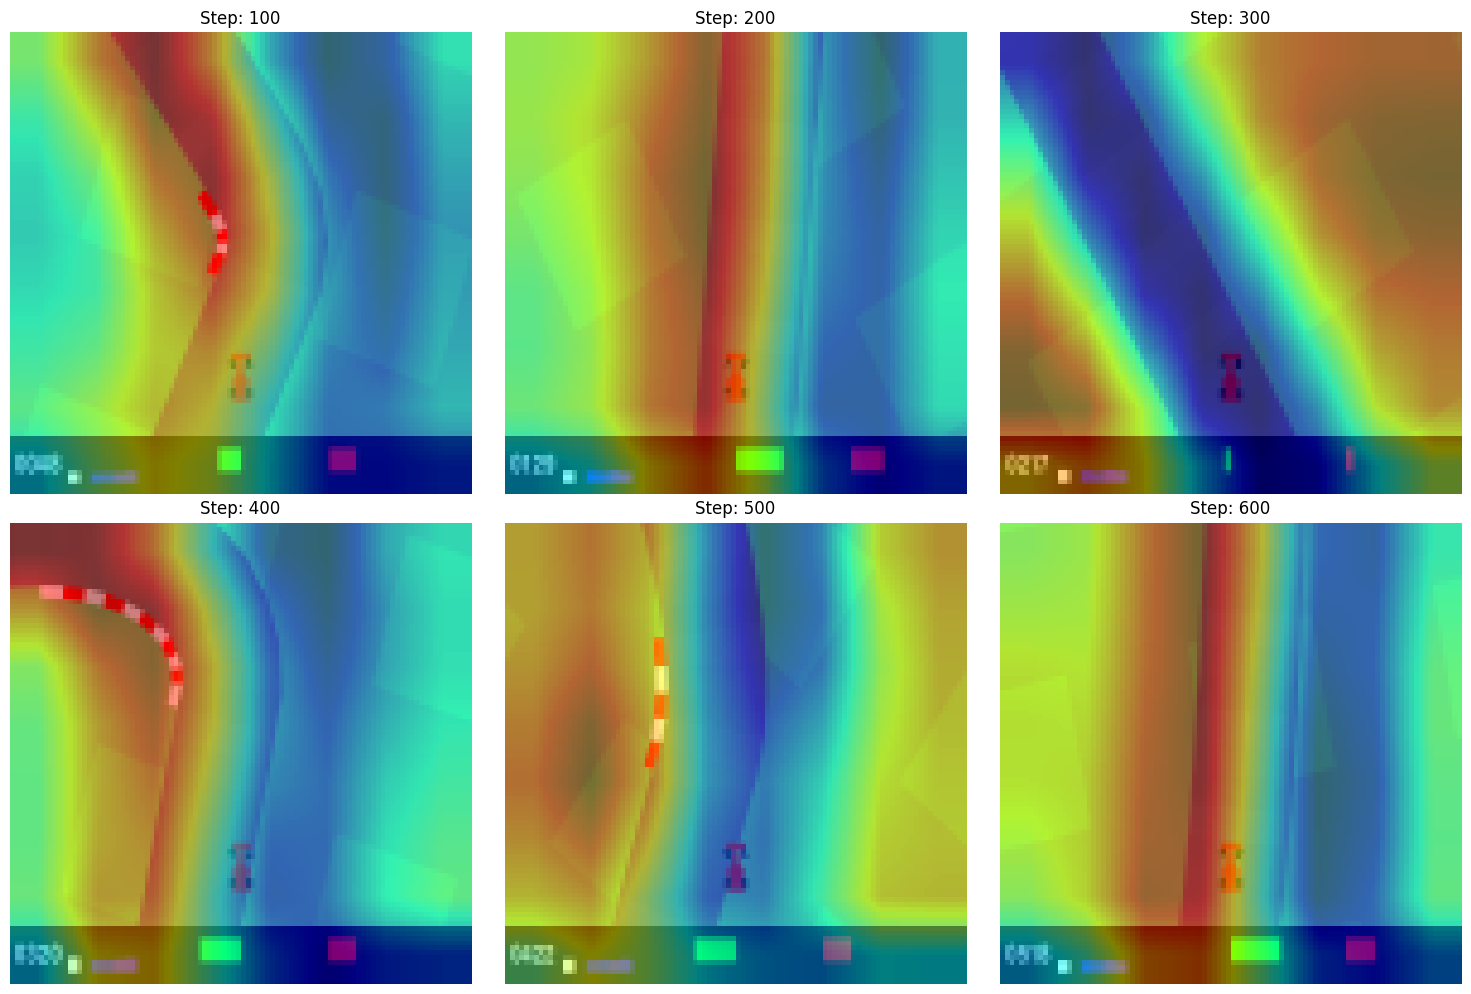

In [168]:
# 必要なライブラリをインポート
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


# --- 1. 可視化ロジックを関数化 ---
def visualize_grad_cam(algo, state, device):
    """
    特定の状態(state)に対してGrad-CAMを実行し、可視化画像を返す関数
    """
    model = algo.cnn
    target_layers = [model.net[4]] # CnnBaseの最後のConv層

    class CriticOutputWrapper(torch.nn.Module):
        def __init__(self, cnn, critic):
            super().__init__()
            self.cnn = cnn
            self.critic = critic
        def forward(self, x):
            features = self.cnn(x)
            return self.critic(features)

    cam_model = CriticOutputWrapper(algo.cnn, algo.critic)
    cam = GradCAM(model=cam_model, target_layers=target_layers)

    # ヒートマップを生成
    input_tensor = preprocess_state(state, device)
    grayscale_cam = cam(input_tensor=input_tensor)[0, :] # バッチ次元を削除

    # 元の画像とヒートマップを重ね合わせ
    rgb_img = state / 255.0
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    return visualization

# --- 2. 可視化したい複数の状態を収集 ---

# (前のセルで学習済みモデルをロードした`best_algo`が必要です)
states_to_visualize = []
# 可視化したいゲーム内のタイムステップを指定
timestamps = [100, 200, 300, 400, 500, 600] 

vis_env = gym.make('CarRacing-v3', render_mode='rgb_array')
state, _ = vis_env.reset(seed=1)

print("可視化用の画像を収集中...")
for i in range(1, max(timestamps) + 1):
    action = best_ppo_algo.exploit(state)
    state, _, done, _, _ = vis_env.step(action)
    if i in timestamps:
        # (タイムステップ, 画像データ) のタプルとして保存
        states_to_visualize.append((i, state.copy()))
        print(f"  - ステップ {i} の画像を保存しました。")
    if done:
        break
vis_env.close()
print("画像の収集が完了しました。")


# --- 3. 収集した画像をグリッド表示 ---
num_images = len(states_to_visualize)
# 1行に3枚ずつ表示するように行数を計算
rows = (num_images + 2) // 3
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten() # 扱いやすいように1次元配列に変換

for i, (step_num, captured_state) in enumerate(states_to_visualize):
    # 各画像に対してGrad-CAMを実行
    vis_image = visualize_grad_cam(best_ppo_algo, captured_state, best_ppo_algo.device)

    # サブプロットに画像を表示
    ax = axes[i]
    ax.imshow(vis_image)
    ax.set_title(f"Step: {step_num}")
    ax.axis('off')

# 画像がない余分なプロットを非表示に
for j in range(num_images, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [159]:
class PPO(Algorithm):
    def __init__(self, state_shape, action_shape, device, seed=0,
                 batch_size=256, gamma=0.99, lr=3e-5,
                 rollout_length=2048, num_updates=10, clip_eps=0.15, lambd=0.95,
                 coef_ent=0.01, max_grad_norm=0.5, reward_scaling=True):
        super().__init__()
        torch.manual_seed(seed)
        if device.type == 'cuda': torch.cuda.manual_seed(seed)
        np.random.seed(seed)

        self.buffer = RolloutBuffer(rollout_length, state_shape, action_shape, device)
        self.device = device

        # モデルの構築
        dummy_state = torch.zeros(1, state_shape[2], state_shape[0], state_shape[1], device=device)
        self.cnn = CNN(input_channels=state_shape[2]).to(device)
        cnn_output_dim = self.cnn(dummy_state).shape[-1]
        self.actor = PPOActor(cnn_output_dim, action_shape).to(device)
        self.critic = PPOCritic(cnn_output_dim).to(device)
        self.optim = torch.optim.Adam(list(self.cnn.parameters()) + list(self.actor.parameters()) + list(self.critic.parameters()), lr=lr)

        self.batch_size = batch_size
        self.gamma = gamma
        self.rollout_length = rollout_length
        self.num_updates = num_updates
        self.clip_eps = clip_eps
        self.lambd = lambd
        self.coef_ent = coef_ent
        self.max_grad_norm = max_grad_norm
        self.reward_scaling=reward_scaling
        if self.reward_scaling:
            self.reward_rms = RunningMeanStd(shape=(1,))

        self.off_course_threshold = 100
        self.off_course_counter = 0


    def explore(self, state):
        state_tensor = preprocess_state(state, self.device)
        with torch.no_grad():
            features = self.cnn(state_tensor)
            action, log_pi = self.actor.sample(features)
        return action.cpu().numpy()[0], log_pi.item()

    def exploit(self, state):
        state_tensor = preprocess_state(state, self.device)
        with torch.no_grad():
            features = self.cnn(state_tensor)
            action = self.actor(features)
        return action.cpu().numpy()[0]

    def is_update(self, steps):
        return steps % self.rollout_length == 0

    def step(self, env, state, t, steps):
        t += 1
        action, log_pi = self.explore(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        if reward < 0:
            self.off_course_counter += 1
        else:
            self.off_course_counter = 0

        if self.off_course_counter >= self.off_course_threshold:
            done = True
            reward = -100

        done_masked = done if not truncated else False
        self.buffer.append(state, action, reward, done_masked, log_pi)

        if done:
            t = 0
            next_state, _ = env.reset()
            self.off_course_counter = 0

        return next_state, t

    def update(self):
        states, actions, rewards, dones, log_pis_old = self.buffer.get()
        processed_states = states.float().permute(0, 3, 1, 2) / 255.0

        if self.reward_scaling:
            self.reward_rms.update(rewards.cpu().numpy())

            scaled_rewards = rewards / torch.sqrt(torch.tensor(self.reward_rms.var, device=self.device, dtype=torch.float32) + 1e-8)
            scaled_rewards = torch.clamp(scaled_rewards, -10.0, 10.0)
        else:
            scaled_rewards = rewards

        with torch.no_grad():
            features = self.cnn(processed_states)
            values = self.critic(features)
            next_features = self.cnn(torch.roll(processed_states, -1, 0))
            next_values = self.critic(next_features)

        targets, advantages = calculate_advantage(values, scaled_rewards, dones, next_values, self.gamma, self.lambd)

        for _ in range(self.num_updates):
            indices = np.random.permutation(self.rollout_length)
            for start in range(0, self.rollout_length, self.batch_size):
                idx = indices[start:start+self.batch_size]
                features_batch = self.cnn(processed_states[idx])

                values_new_batch = self.critic(features_batch)
                values_old_batch = values[idx]

                values_clipped = values_old_batch + torch.clamp(
                    values_new_batch - values_old_batch, -self.clip_eps, self.clip_eps
                )

                # 4. 2種類の損失を計算
                loss_critic_unclipped = (values_new_batch - targets[idx]).pow(2)
                loss_critic_clipped = (values_clipped - targets[idx]).pow(2)

                loss_critic = 0.5 * torch.max(loss_critic_unclipped, loss_critic_clipped).mean()

                # Actor損失
                log_pis = evaluate_lop_pi(self.actor.fc(features_batch), self.actor.log_stds, actions[idx])
                mean_entropy = -log_pis.mean()
                ratios = (log_pis - log_pis_old[idx]).exp()
                loss_actor1 = -ratios * advantages[idx]
                loss_actor2 = -torch.clamp(ratios, 1.0 - self.clip_eps, 1.0 + self.clip_eps) * advantages[idx]
                loss_actor = torch.max(loss_actor1, loss_actor2).mean() - self.coef_ent * mean_entropy

                # 合計損失
                total_loss = loss_actor + 0.5 * loss_critic

                self.optim.zero_grad()
                total_loss.backward()
                nn.utils.clip_grad_norm_(self.cnn.parameters(), self.max_grad_norm)
                nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
                nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
                self.optim.step()

    def save_models(self, save_dir):
        """モデルの重みを保存する"""
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        torch.save(self.cnn.state_dict(), os.path.join(save_dir, 'cnn.pth'))
        torch.save(self.actor.state_dict(), os.path.join(save_dir, 'actor.pth'))
        torch.save(self.critic.state_dict(), os.path.join(save_dir, 'critic.pth'))
        print(f"モデルを {save_dir} に保存しました。")

    def load_models(self, load_dir):
        """モデルの重みを読み込む"""
        self.cnn.load_state_dict(torch.load(os.path.join(load_dir, 'cnn.pth')))
        self.actor.load_state_dict(torch.load(os.path.join(load_dir, 'actor.pth')))
        self.critic.load_state_dict(torch.load(os.path.join(load_dir, 'critic.pth')))
        print(f"モデルを {load_dir} から読み込みました。")

In [140]:
SEED = 0
NUM_STEPS = 5 * 10**5
EVAL_INTERVAL = 2048

env = gym.make('CarRacing-v3', render_mode='rgb_array', max_episode_steps=1000)
env_test = gym.make('CarRacing-v3', render_mode='rgb_array', max_episode_steps=1000)

algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    reward_scaling=False
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
    model_dir='best_ppo_2'
)

In [141]:
trainer.train()

Num steps: 2048     Return: -41.2   Time: 0:00:31
最高スコアを記録: -41.2
モデルを best_ppo_2 に保存しました。
Num steps: 4096     Return: -78.9   Time: 0:00:52
Num steps: 6144     Return: -58.5   Time: 0:01:24
Num steps: 8192     Return: -65.4   Time: 0:01:55
Num steps: 10240    Return: -61.9   Time: 0:02:27
Num steps: 12288    Return: -64.7   Time: 0:02:49
Num steps: 14336    Return: -61.9   Time: 0:03:20
Num steps: 16384    Return: -27.3   Time: 0:03:52
最高スコアを記録: -27.3
モデルを best_ppo_2 に保存しました。
Num steps: 18432    Return: -70.0   Time: 0:04:17
Num steps: 20480    Return: -60.7   Time: 0:04:41
Num steps: 22528    Return: -50.4   Time: 0:05:07
Num steps: 24576    Return: 34.9    Time: 0:05:46
最高スコアを記録: 34.9
モデルを best_ppo_2 に保存しました。
Num steps: 26624    Return: 225.3   Time: 0:06:22
最高スコアを記録: 225.3
モデルを best_ppo_2 に保存しました。
Num steps: 28672    Return: 249.5   Time: 0:06:57
最高スコアを記録: 249.5
モデルを best_ppo_2 に保存しました。
Num steps: 30720    Return: 7.3     Time: 0:07:32
Num steps: 32768    Return: 211.4   Time: 0:08

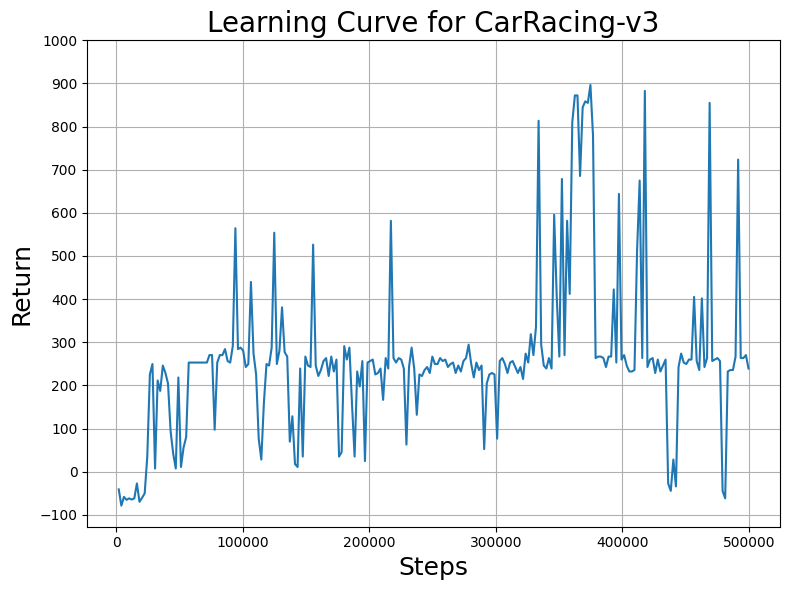

In [142]:
trainer.plot()

In [160]:
env.close()
env_test.close()

In [161]:
env = gym.make('CarRacing-v3', render_mode='rgb_array', max_episode_steps=1000)
best_ppo_algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

best_ppo_algo.load_models('best_ppo_2')

video_folder = "best_ppo_2_videos"
env = RecordVideo(env, video_folder, episode_trigger=lambda e: True)
state, _ = env.reset(seed=4)
done = False
while not done:
    action = best_ppo_algo.exploit(state)
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
env.close()

play_mp4(video_folder)

モデルを best_ppo_2 から読み込みました。
表示中の動画: best_ppo_2_videos/rl-video-episode-0.mp4


In [162]:
class PPO(Algorithm):
    def __init__(self, state_shape, action_shape, device, seed=0,
                 batch_size=256, gamma=0.99, lr=3e-5,
                 rollout_length=2048, num_updates=10, clip_eps=0.2, lambd=0.95,
                 coef_ent=0.01, max_grad_norm=0.5, reward_scaling=True, num_steps=10**6):
        super().__init__()
        torch.manual_seed(seed)
        if device.type == 'cuda': torch.cuda.manual_seed(seed)
        np.random.seed(seed)

        self.buffer = RolloutBuffer(rollout_length, state_shape, action_shape, device)
        self.device = device

        # モデルの構築
        dummy_state = torch.zeros(1, state_shape[2], state_shape[0], state_shape[1], device=device)
        self.cnn_actor = CNN(input_channels=state_shape[2]).to(device)
        self.cnn_critic = CNN(input_channels=state_shape[2]).to(device)

        cnn_output_dim = self.cnn_actor(dummy_state).shape[-1]
        self.actor = PPOActor(cnn_output_dim, action_shape).to(device)
        self.critic = PPOCritic(cnn_output_dim).to(device)
        self.optim = torch.optim.Adam(list(self.cnn_actor.parameters()) + list(self.cnn_critic.parameters()) + list(self.actor.parameters()) + list(self.critic.parameters()), lr=lr, eps=1e-5)
        total_updates = num_steps // rollout_length
        
        self.scheduler = LinearLR(
            self.optim,
            start_factor=1.0, # 開始時の学習率の倍率 (100%)
            end_factor=0.0,   # 終了時の学習率の倍率 (0%)
            total_iters=total_updates # 総更新回数
        )

        self.batch_size = batch_size
        self.gamma = gamma
        self.rollout_length = rollout_length
        self.num_updates = num_updates
        self.clip_eps = clip_eps
        self.lambd = lambd
        self.coef_ent = coef_ent
        self.max_grad_norm = max_grad_norm
        self.reward_scaling=reward_scaling
        if self.reward_scaling:
            self.reward_rms = RunningMeanStd(shape=(1,))

        self.off_course_threshold = 100
        self.off_course_counter = 0


    def explore(self, state):
        state_tensor = preprocess_state(state, self.device)
        with torch.no_grad():
            features = self.cnn_actor(state_tensor)
            action, log_pi = self.actor.sample(features)
        return action.cpu().numpy()[0], log_pi.item()

    def exploit(self, state):
        state_tensor = preprocess_state(state, self.device)
        with torch.no_grad():
            features = self.cnn_actor(state_tensor)
            action = self.actor(features)
        return action.cpu().numpy()[0]

    def is_update(self, steps):
        return steps % self.rollout_length == 0

    def step(self, env, state, t, steps):
        t += 1
        action, log_pi = self.explore(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        if reward < 0:
            self.off_course_counter += 1
        else:
            self.off_course_counter = 0

        if self.off_course_counter >= self.off_course_threshold:
            done = True
            reward = -100

        done_masked = done if not truncated else False
        self.buffer.append(state, action, reward, done_masked, log_pi)

        if done:
            t = 0
            next_state, _ = env.reset()
            self.off_course_counter = 0

        return next_state, t

    def update(self):
        states, actions, rewards, dones, log_pis_old = self.buffer.get()
        processed_states = states.float().permute(0, 3, 1, 2) / 255.0

        if self.reward_scaling:
            self.reward_rms.update(rewards.cpu().numpy())

            scaled_rewards = rewards / torch.sqrt(torch.tensor(self.reward_rms.var, device=self.device, dtype=torch.float32) + 1e-8)
            scaled_rewards = torch.clamp(scaled_rewards, -10.0, 10.0)
        else:
            scaled_rewards = rewards

        with torch.no_grad():
            features_critic = self.cnn_critic(processed_states)
            values = self.critic(features_critic)
            next_features_critic = self.cnn_critic(torch.roll(processed_states, -1, 0))
            next_values = self.critic(next_features_critic)

        targets, advantages = calculate_advantage(values, scaled_rewards, dones, next_values, self.gamma, self.lambd)

        for _ in range(self.num_updates):
            indices = np.random.permutation(self.rollout_length)
            for start in range(0, self.rollout_length, self.batch_size):
                idx = indices[start:start+self.batch_size]
                features_actor_batch = self.cnn_actor(processed_states[idx])
                features_critic_batch = self.cnn_critic(processed_states[idx])

                values_new_batch = self.critic(features_critic_batch)
                values_old_batch = values[idx]

                values_clipped = values_old_batch + torch.clamp(
                    values_new_batch - values_old_batch, -self.clip_eps, self.clip_eps
                )

                # 4. 2種類の損失を計算
                loss_critic_unclipped = (values_new_batch - targets[idx]).pow(2)
                loss_critic_clipped = (values_clipped - targets[idx]).pow(2)

                # 5. 大きい方の損失を採用し、平均を取る
                loss_critic = 0.5 * torch.max(loss_critic_unclipped, loss_critic_clipped).mean()

                # Actor損失
                log_pis = evaluate_lop_pi(self.actor.fc(features_actor_batch), self.actor.log_stds, actions[idx])
                mean_entropy = -log_pis.mean()
                ratios = (log_pis - log_pis_old[idx]).exp()
                loss_actor1 = -ratios * advantages[idx]
                loss_actor2 = -torch.clamp(ratios, 1.0 - self.clip_eps, 1.0 + self.clip_eps) * advantages[idx]
                loss_actor = torch.max(loss_actor1, loss_actor2).mean() - self.coef_ent * mean_entropy

                total_loss = loss_actor + 0.5 * loss_critic

                self.optim.zero_grad()
                total_loss.backward()
                nn.utils.clip_grad_norm_(self.cnn_actor.parameters(), self.max_grad_norm)
                nn.utils.clip_grad_norm_(self.cnn_critic.parameters(), self.max_grad_norm)
                nn.utils.clip_grad_norm_(self.actor.parameters(), self.max_grad_norm)
                nn.utils.clip_grad_norm_(self.critic.parameters(), self.max_grad_norm)
                self.optim.step()
        
        self.scheduler.step()

    def save_models(self, save_dir):
        """モデルの重みを保存する"""
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        torch.save(self.cnn_actor.state_dict(), os.path.join(save_dir, 'cnn_actor.pth'))
        torch.save(self.cnn_critic.state_dict(), os.path.join(save_dir, 'cnn_critic.pth'))
        torch.save(self.actor.state_dict(), os.path.join(save_dir, 'actor.pth'))
        torch.save(self.critic.state_dict(), os.path.join(save_dir, 'critic.pth'))
        print(f"モデルを {save_dir} に保存しました。")

    def load_models(self, load_dir):
        """モデルの重みを読み込む"""
        self.cnn_actor.load_state_dict(torch.load(os.path.join(load_dir, 'cnn_actor.pth')))
        self.cnn_critic.load_state_dict(torch.load(os.path.join(load_dir, 'cnn_critic.pth')))
        self.actor.load_state_dict(torch.load(os.path.join(load_dir, 'actor.pth')))
        self.critic.load_state_dict(torch.load(os.path.join(load_dir, 'critic.pth')))
        print(f"モデルを {load_dir} から読み込みました。")

In [ ]:
SEED = 0
NUM_STEPS = 5 * 10**5
EVAL_INTERVAL = 512

env = gym.make('CarRacing-v3', render_mode='rgb_array', max_episode_steps=1000)
env_test = gym.make('CarRacing-v3', render_mode='rgb_array', max_episode_steps=1000)

algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    reward_scaling=False,
    num_steps=NUM_STEPS
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
    model_dir='best_ppo_3'
)

In [ ]:
trainer.train()

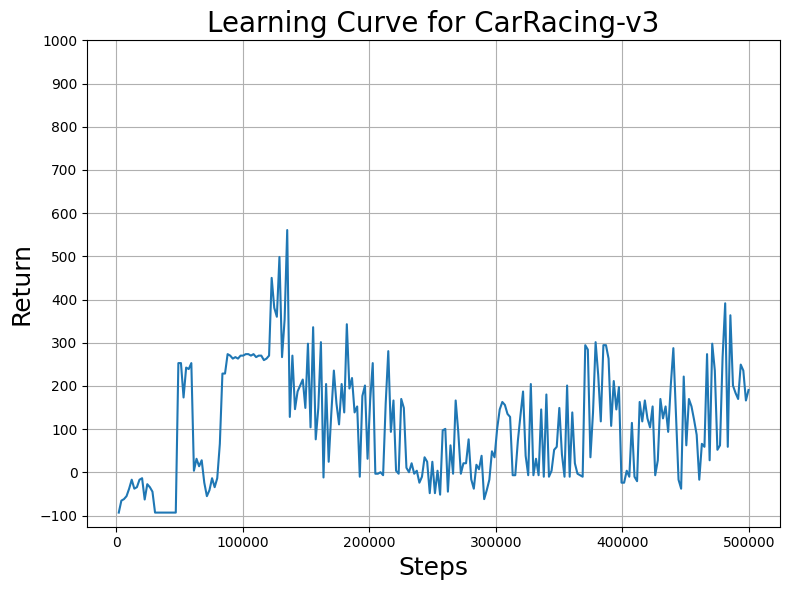

In [105]:
trainer.plot()

In [163]:
env.close()
env_test.close()

In [164]:
env = gym.make('CarRacing-v3', render_mode='rgb_array', max_episode_steps=1000)
best_ppo_algo = PPO(
    state_shape=env.observation_space.shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

best_ppo_algo.load_models('best_ppo_3')

video_folder = "best_ppo_3_videos"
env = RecordVideo(env, video_folder, episode_trigger=lambda e: True)
state, _ = env.reset(seed=SEED)
done = False
while not done:
    action = best_ppo_algo.exploit(state)
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
env.close()

play_mp4(video_folder)

モデルを best_ppo_3 から読み込みました。


/opt/miniconda3/envs/car-racing-env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /Users/todayuto/Downloads/best_ppo_3_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


表示中の動画: best_ppo_3_videos/rl-video-episode-0.mp4
